In [ ]:
!pip install pywaffle

: 

In [ ]:
# --- Importation des librairies ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_profiling
import seaborn as sns
import warnings
import os
import yellowbrick
import scipy.cluster.hierarchy as shc
import matplotlib.patches as patches

from matplotlib.patches import Rectangle
from pandas_profiling import ProfileReport
from pywaffle import Waffle
from math import isnan
from random import sample
from numpy.random import uniform
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.style import set_palette
from yellowbrick.contrib.wrapper import wrap

# --- Configuration des librairies ---
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 600
sns.set(rc = {'axes.facecolor': '#FBFBFB', 'figure.facecolor': '#FBFBFB'})
class clr:
    start = '\033[93m'+'\033[1m'
    color = '\033[93m'
    end = '\033[0m'

In [ ]:
df = pd.read_csv("../data/donnees_bancaires.csv")
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,...,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,CREDIT_CARD_TYPE,ACCOUNT_TYPE,INCOME_CATEGORY,TYPE_OF_ECO_ACTIVITY
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,...,2,1000.0,201.802084,139.509787,0.000000,12,Visa,Compte épargne,Moyen,Entreprises
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,...,0,7000.0,4103.032597,1072.340217,0.222222,12,Visa,Compte courant,Élevé,Entreprises
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,...,12,7500.0,622.066742,627.284787,0.000000,12,Visa,Compte courant,Bas,Entreprises
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,...,1,7500.0,0.000000,NaN,0.000000,12,MasterCard,Compte courant,Moyen,Particuliers
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,...,1,1200.0,678.334763,244.791237,0.000000,12,American Express,Compte courant,Élevé,Entreprises


In [ ]:
# --- Reading Train Dataset ---
print(clr.start+'.: Importation du jeu de données :.'+clr.end)
print(clr.color+'*' * 23)
df.head().style.background_gradient(cmap='YlOrBr').hide_index()

.: Importation du jeu de données :.
***********************


CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,CREDIT_CARD_TYPE,ACCOUNT_TYPE,INCOME_CATEGORY,TYPE_OF_ECO_ACTIVITY
C10001,40.900749,0.818182,95.400000,0.000000,95.400000,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.000000,201.802084,139.509787,0.000000,12,Visa,Compte épargne,Moyen,Entreprises
C10002,3202.467416,0.909091,0.000000,0.000000,0.000000,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.000000,4103.032597,1072.340217,0.222222,12,Visa,Compte courant,Élevé,Entreprises
C10003,2495.148862,1.000000,773.170000,773.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.000000,622.066742,627.284787,0.000000,12,Visa,Compte courant,Bas,Entreprises
C10004,1666.670542,0.636364,1499.000000,1499.000000,0.000000,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.000000,0.000000,nan,0.000000,12,MasterCard,Compte courant,Moyen,Particuliers
C10005,817.714335,1.000000,16.000000,16.000000,0.000000,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.000000,678.334763,244.791237,0.000000,12,American Express,Compte courant,Élevé,Entreprises


### CUST_ID est l'identifiant unique de chaque client dans la base de données de la banque.
### BALANCE représente le solde du compte du client.
### BALANCE_FREQUENCY représente la fréquence à laquelle le client vérifie son solde, exprimée en nombre de fois par mois.
### PURCHASES représente le montant total des achats effectués par le client sur son compte.
### ONEOFF_PURCHASES représente le montant total des achats effectués en une seule fois par le client.
### INSTALLMENTS_PURCHASES représente le montant total des achats effectués en plusieurs fois par le client.
### CASH_ADVANCE représente le montant total des avances de fonds effectuées par le client sur son compte.
### PURCHASES_FREQUENCY représente la fréquence à laquelle le client effectue des achats sur son compte.
### ONEOFF_PURCHASES_FREQUENCY représente la fréquence à laquelle le client effectue des achats en une seule fois sur son compte.
### PURCHASES_INSTALLMENTS_FREQUENCY représente la fréquence à laquelle le client effectue des achats en plusieurs fois sur son compte.
### CASH_ADVANCE_FREQUENCY représente la fréquence à laquelle le client effectue des avances de fonds sur son compte.
### CASH_ADVANCE_TRX représente le nombre total de transactions d'avance de fonds effectuées par le client sur son compte.
### PURCHASES_TRX représente le nombre total de transactions d'achat effectuées par le client sur son compte.
### CREDIT_LIMIT représente la limite de crédit du client, c'est-à-dire le montant maximum qu'il peut dépenser sur son compte.
### PAYMENTS représente le montant total des paiements effectués par le client sur son compte.
### MINIMUM_PAYMENTS représente le montant minimum des paiements que le client doit effectuer chaque mois sur son compte.
### PRC_FULL_PAYMENT représente le pourcentage du solde du compte qui est payé en entier chaque mois par le client.
### TENURE représente le nombre de mois pendant lesquels le client a été client de la banque.
### CREDIT_CARD_TYPE: Cette variable représente le type de carte de crédit que le client possède, qui peut être Visa, MasterCard, American Express ou d'autres types de cartes de crédit disponibles dans la banque. C'est une variable catégorielle nominale.
### ACCOUNT_TYPE: Cette variable représente le type de compte bancaire que le client possède, qui peut être un compte courant, un compte épargne, un compte chèque ou d'autres types de comptes disponibles dans la banque. C'est une variable catégorielle nominale(Compte courant, compte épargne)
### INCOME_CATEGORY: Cette variable représente la catégorie de revenu du client, qui peut être bas, moyen, élevé ou d'autres catégories selon la définition de la banque. C'est une variable catégorielle ordinale(Bas, moyen, élevé)
### TYPE_OF_ECO_ACTIVITY: Cette variable représente le type d'activité économique du client, qui peut être des entreprises, des particuliers, des investisseurs ou d'autres types d'activités économiques selon la définition de la banque. C'est une variable catégorielle nominale(Entreprises, particuliers, investisseurs)

# <div class="header1">4. | Analyse Exploratoires de base 🔍</div>
<div class="explain-box">
  
</div>

In [ ]:
# --- Dataset Report ---
ProfileReport(df, title='Informations des données banque', minimal=True, progress_bar=False, samples=None, correlations=None, interactions=None, explorative=True, dark_mode=True, notebook={'iframe':{'height': '600px'}}, html={'style':{'primary_color': '#FFCC00'}}, missing_diagrams={'heatmap': True, 'dendrogram': True}).to_notebook_iframe()

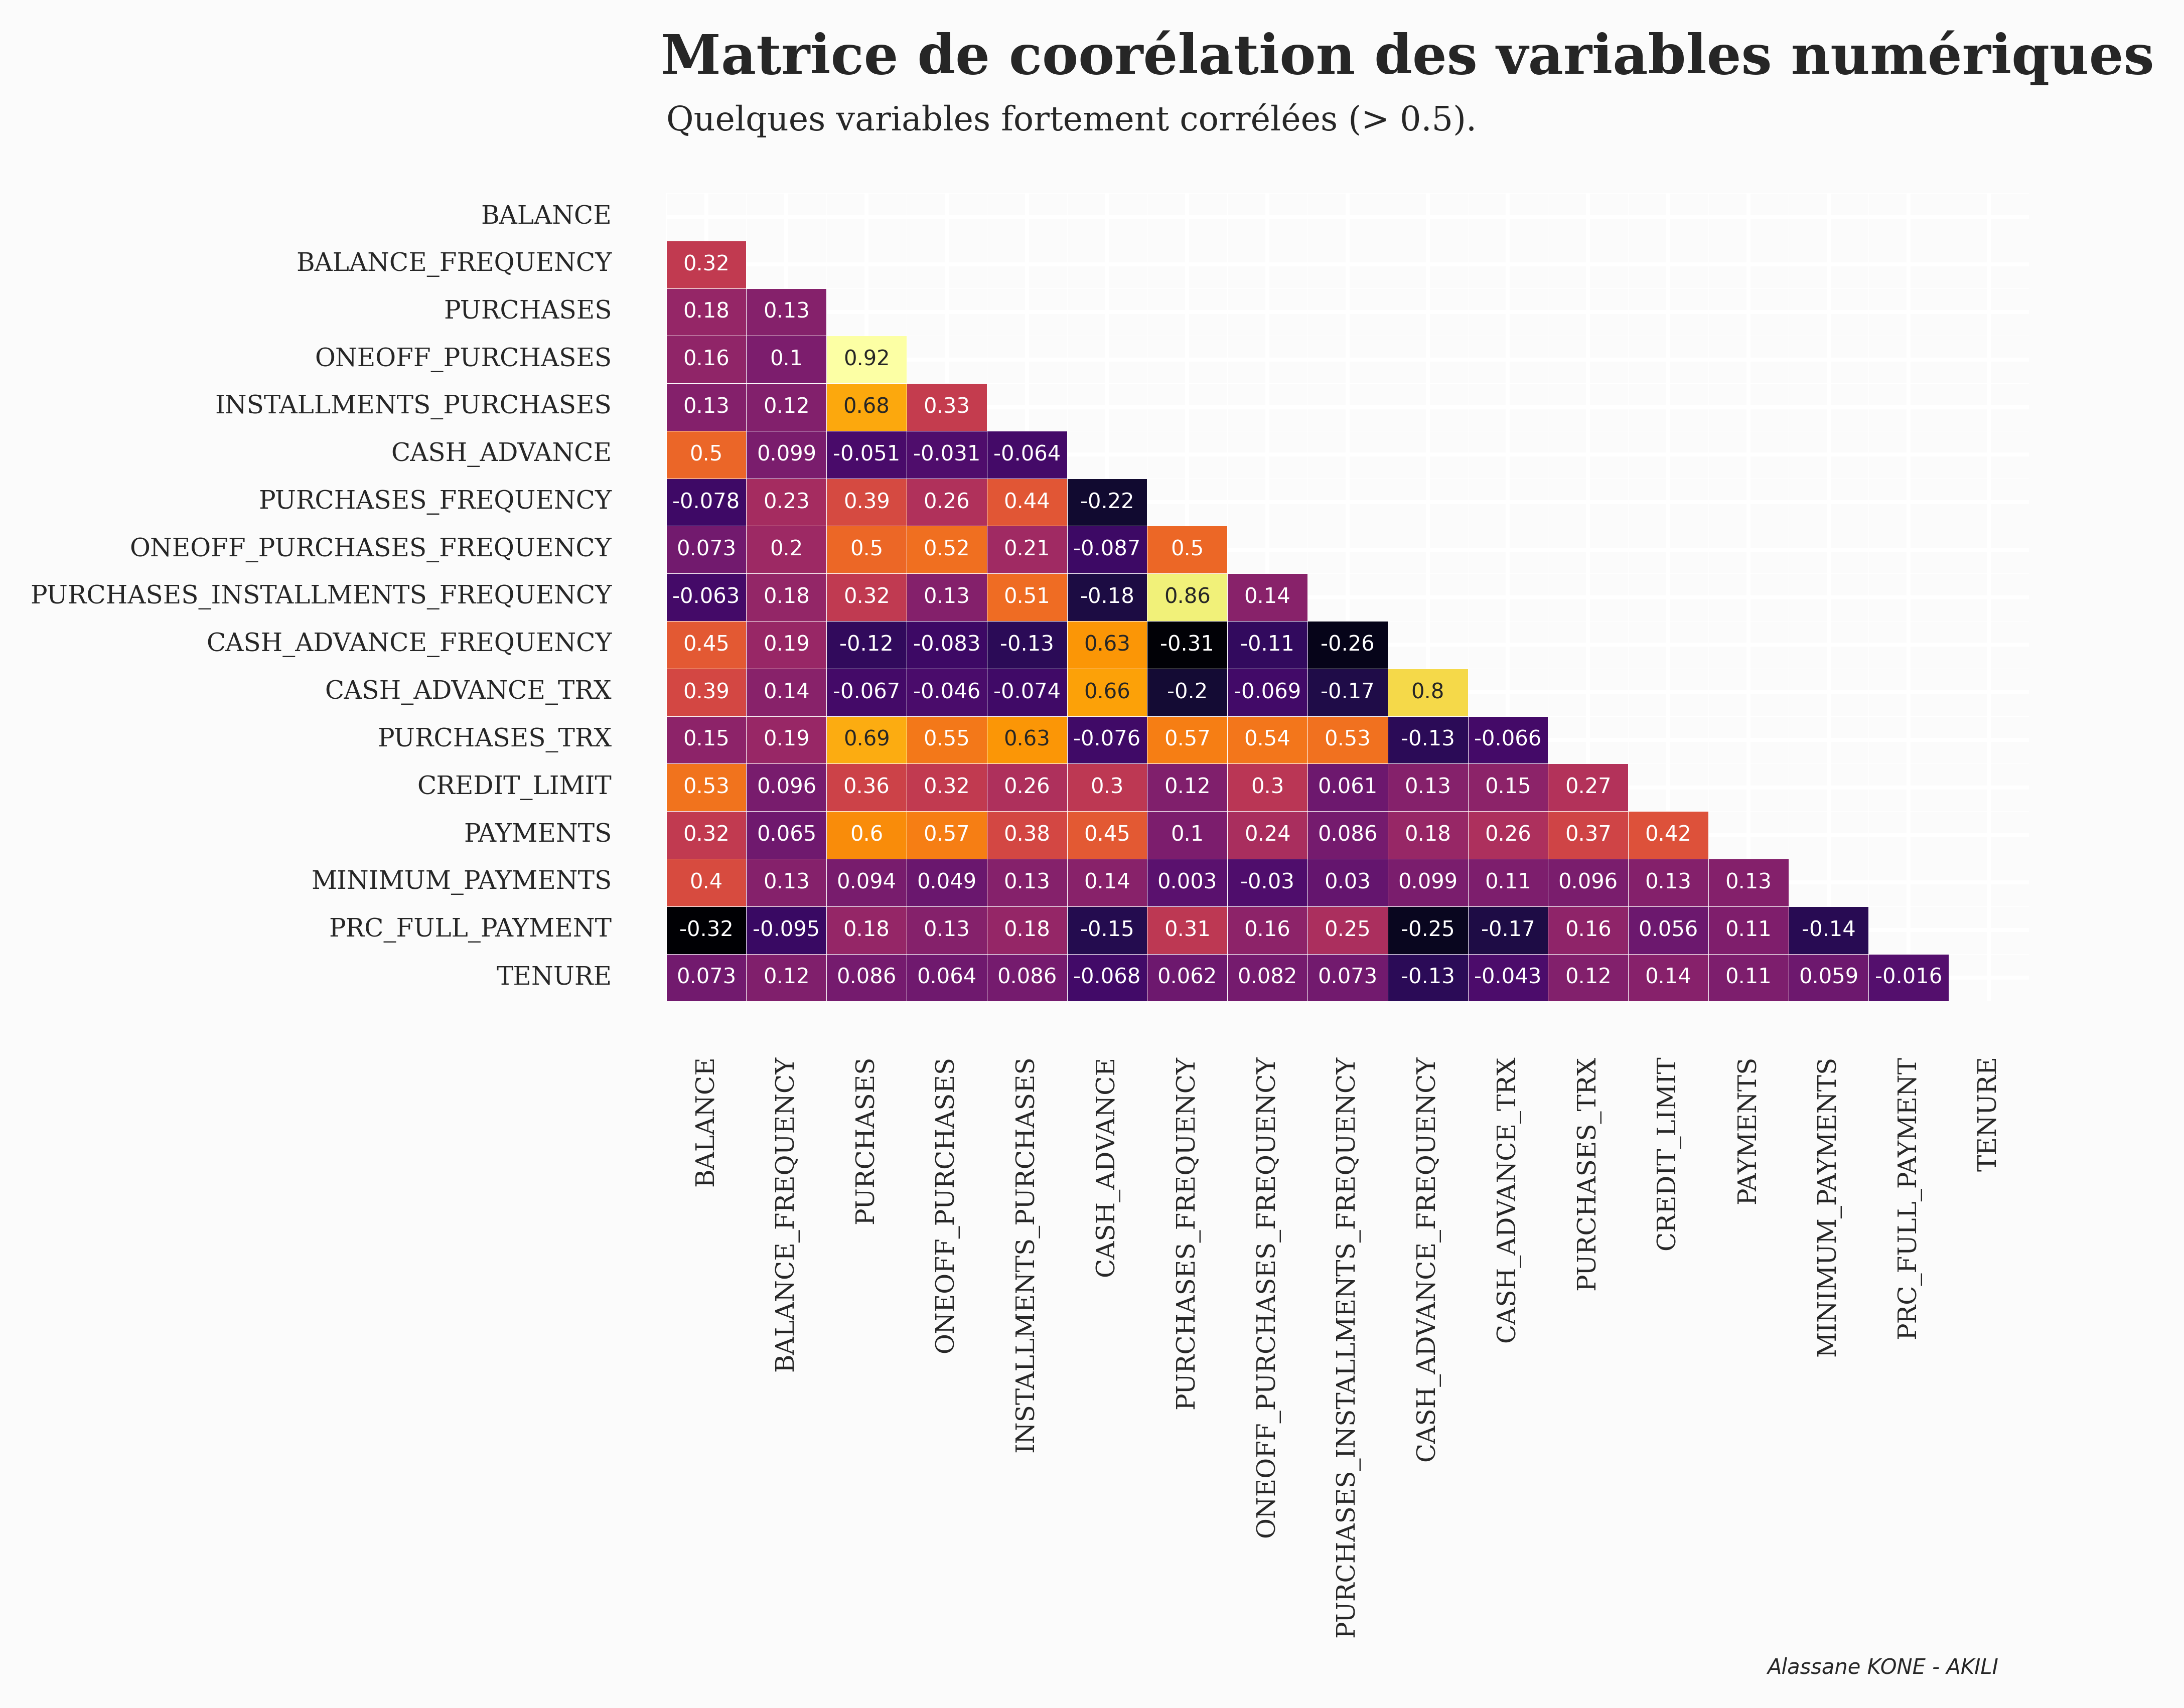

In [ ]:
# --- Matrice de corrélation ---
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(df.corr(), mask=mask, annot=True, cmap='inferno', linewidths=0.1, cbar=False, annot_kws={"size":5})
yticks, ylabels = plt.yticks()
xticks, xlabels = plt.xticks()
ax.set_xticklabels(xlabels, size=6, fontfamily='serif')
ax.set_yticklabels(ylabels, size=6, fontfamily='serif')
plt.suptitle('Matrice de coorélation des variables numériques', fontweight='heavy', x=0.325, y=0.96, ha='left', fontsize=13, fontfamily='serif')
plt.title('Quelques variables fortement corrélées (> 0.5).\n', fontsize=8, fontfamily='serif', loc='left')
plt.tight_layout(rect=[0, 0.04, 1, 1.01])
plt.gcf().text(0.85, 0.05, 'Alassane KONE - AKILI', style='italic', fontsize=5)
plt.show()

<div class="explain-box">
    A partir <b> des analyses </b> et  <b>la matrice de corrélation des données, on peut conclure que:
    <blockquote style="color: #000000;"><br>
<ul>
  <li>
  Il y a des valeurs manquantes dans les variables CREDIT_LIMIT (1 valeur manquante) et MINIMUM_PAYMENTS :  
    <mark> 
        313 valeurs manquantes soit 3,5%.
    </mark>
  </li><br>
            
  <li>
      La plupart des colonnes ont un nombre massif de valeurs à 0. De plus,
       fortement asymétriques vers la droite, 
       comme cela est visible sur les histogrammes et la comparaison des valeurs moyennes et médianes :
       <mark> 
          les valeurs moyennes sont inférieures aux valeurs médianes
          </mark>
  </li><br>

  <li> 
      Certaines variables ont des valeurs de corrélation modérées à élevées avec d'autres variables (>0,5 à 1). 
      Des exemples de variables fortement corrélées sont, 
      <mark>
            PURCHASES et ONEOFF_PURCHASES
      </mark>, avec une valeur de corrélation de 0,92. Un autre exemple est 
      <mark>
          CASH_ADVANCE_TRX avec CASH_ADVANCE_FREQUENCY
      </mark> avec une valeur de corrélation de 0,8.
      </li><br>

  <li>
     Lorsqu'ils utilisent une carte de crédit, 
     <b>
    la plupart des clients préfèrent une durée de remboursement de 12 mois
  </b>, par rapport à d'autres options de durée. On peut en conclure que 
  <mark> 
    les clients sont plus susceptibles de rembourser leur crédit à long terme  avec pour conséquence un taux d'intérêt plus élevé. 
  </mark>
  </li><br>
            
  <li>
      <b>
      Lors de l'analyse approfondie de la colonne BALANCE, il apparaît qu'il y a beaucoup de cartes de crédit avec un solde de 0. Cela est également confirmé par le grand nombre de montants d'achats à 0 dans la colonne PURCHASES. Sur la base de ces résultats,
      </b> 
      on peut supposer que, 
      <mark>
      certains utilisateurs maintiennent délibérément un faible solde sur leur compte afin d'obtenir une limite de crédit élevée, 
       </mark> ce qui augmente le taux d'utilisation du crédit et le score de crédit.</li><br>

  <li>
  La plupart des comptes de cartes de crédit ont un score de 1 dans la colonne BALANCE_FREQUENCY, 
  <mark> ce qui indique que la plupart des clients utilisent fréquemment leur carte de crédit.
  </mark> Cependant, cela diffère de 
  <b>
  ONEOFF_PURCHASES et PURCHASES_INSTALLMENT_FREQUENCY
  </b>, où la majorité  
  <mark> 
  des clients n'utilisent pas leur carte de crédit pour des transactions ponctuelles ou des paiements en plusieurs fois.
  </mark>
  </li>
</div>

# <div class="header1">5. | Analyses Exploratoires avancées📈</div>
<div class="explain-box">
    
</div>

## <div class="header2">5.1 | Credit Limit vs. Balance based on Tenure 💳💰⌛</div>


In [ ]:
# --- EDA 1 Variables ---
scatter_style=dict(linewidth=0.65, edgecolor='#100C07', alpha=0.85)
sub_scatter_style_color=dict(s=5, alpha=0.65, linewidth=0.15, zorder=10, edgecolor='#100C07')
sub_scatter_style_grey=dict(s=5, alpha=0.3, linewidth=0.7, zorder=5, color='#CAC9CD')
grid_style=dict(alpha=0.3, color='#9B9A9C', linestyle='dotted', zorder=1)
xy_label=dict(fontweight='bold', fontsize=14, fontfamily='serif')
suptitle=dict(fontsize=22, fontweight='heavy', fontfamily='serif')
title=dict(fontsize=16, fontfamily='serif')
color_pallete=['#2D0F51', '#FF9A00', '#6600A5', '#FFD61E', '#722E9A', '#FFE863', '#A486D5']
sub_axes=[None] * 7

# --- EDA 1 Data Frame ---
eda1 = df[['CREDIT_LIMIT', 'BALANCE', 'TENURE']]
eda1['TENURE'] = eda1['TENURE'].astype(str)
tenure = sorted(eda1['TENURE'].unique())

# --- EDA 1 Settings ---
fig = plt.figure(figsize=(22, 14))
gs = fig.add_gridspec(7, 7)
ax = fig.add_subplot(gs[:, :7])
ax.set_aspect(1)

# --- EDA 1: Main Scatter Plot ---
for x in range(len(tenure)):
    eda1_x = eda1[eda1['TENURE']==tenure[x]]
    ax.scatter(eda1_x['CREDIT_LIMIT'], eda1_x['BALANCE'], s=80, color=color_pallete[x], **scatter_style)
    ax.set_title('There are positive correlation between both variables. Most credit card customers prefer 12 months.\n', loc='left', **title)
    ax.set_xlabel('\nCREDIT_LIMIT', **xy_label)
    ax.set_ylabel('BALANCE\n', **xy_label)
    ax.grid(axis='y', which='major', **grid_style)
    ax.grid(axis='x', which='major', **grid_style)
    for spine in ax.spines.values():
        spine.set_color('None')
    for spine in ['bottom', 'left']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('#CAC9CD')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

# --- EDA 1: Sub Plots ---
for idx, tnr in enumerate(tenure):
    sub_axes[idx] = fig.add_subplot(gs[idx, 6], aspect=1)
    
    sub_axes[idx].scatter(eda1[eda1['TENURE']!=tnr]['CREDIT_LIMIT'], eda1[eda1['TENURE']!=tnr]['BALANCE'], label=tnr, **sub_scatter_style_grey)
    sub_axes[idx].scatter(eda1[eda1['TENURE']==tnr]['CREDIT_LIMIT'], eda1[eda1['TENURE']==tnr]['BALANCE'], color=color_pallete[idx], label=tnr, **sub_scatter_style_color)
    
    cnt = (eda1['TENURE']==tnr).sum()
    sub_axes[idx].set_title(f'Tenure {tnr} - ({cnt})', loc='left', fontsize=10, fontfamily='serif')
    sub_axes[idx].set_xticks([])
    sub_axes[idx].set_yticks([])
    for spine in sub_axes[idx].spines.values():
        spine.set_color('None')

# --- EDA 1 XY Limit ---
for axes in [ax] + sub_axes:
    axes.set_xlim(-1000, 31000)
    axes.set_ylim(-1000, 20000)

# --- EDA 1 Title ---
plt.suptitle('Scatter Plot Credit Limit vs. Balance based on Tenure', x=0.145, y=0.945, ha='left', **suptitle)
plt.gcf().text(0.81, 0.05, 'Alassane KONE - AKILI', style='italic', fontsize=11)
plt.show();

Output hidden; open in https://colab.research.google.com to view.

<div class="explain-box">
    Le graphique en nuage de points montre que <b>lorsque les valeurs des variables augmentent, la distribution/variance résiduelle augmente également</b> jusqu'à former une forme de cône (<mark><b>hétéroscédasticité</b></mark>). De plus, comme mentionné précédemment, <b>la plupart des clients de cartes de crédit préfèrent une durée de remboursement de 12 mois</b>.
</div>


## <div class="header2">5.2 | Purchases Amount vs. Total Transaction 💸🔁</div>


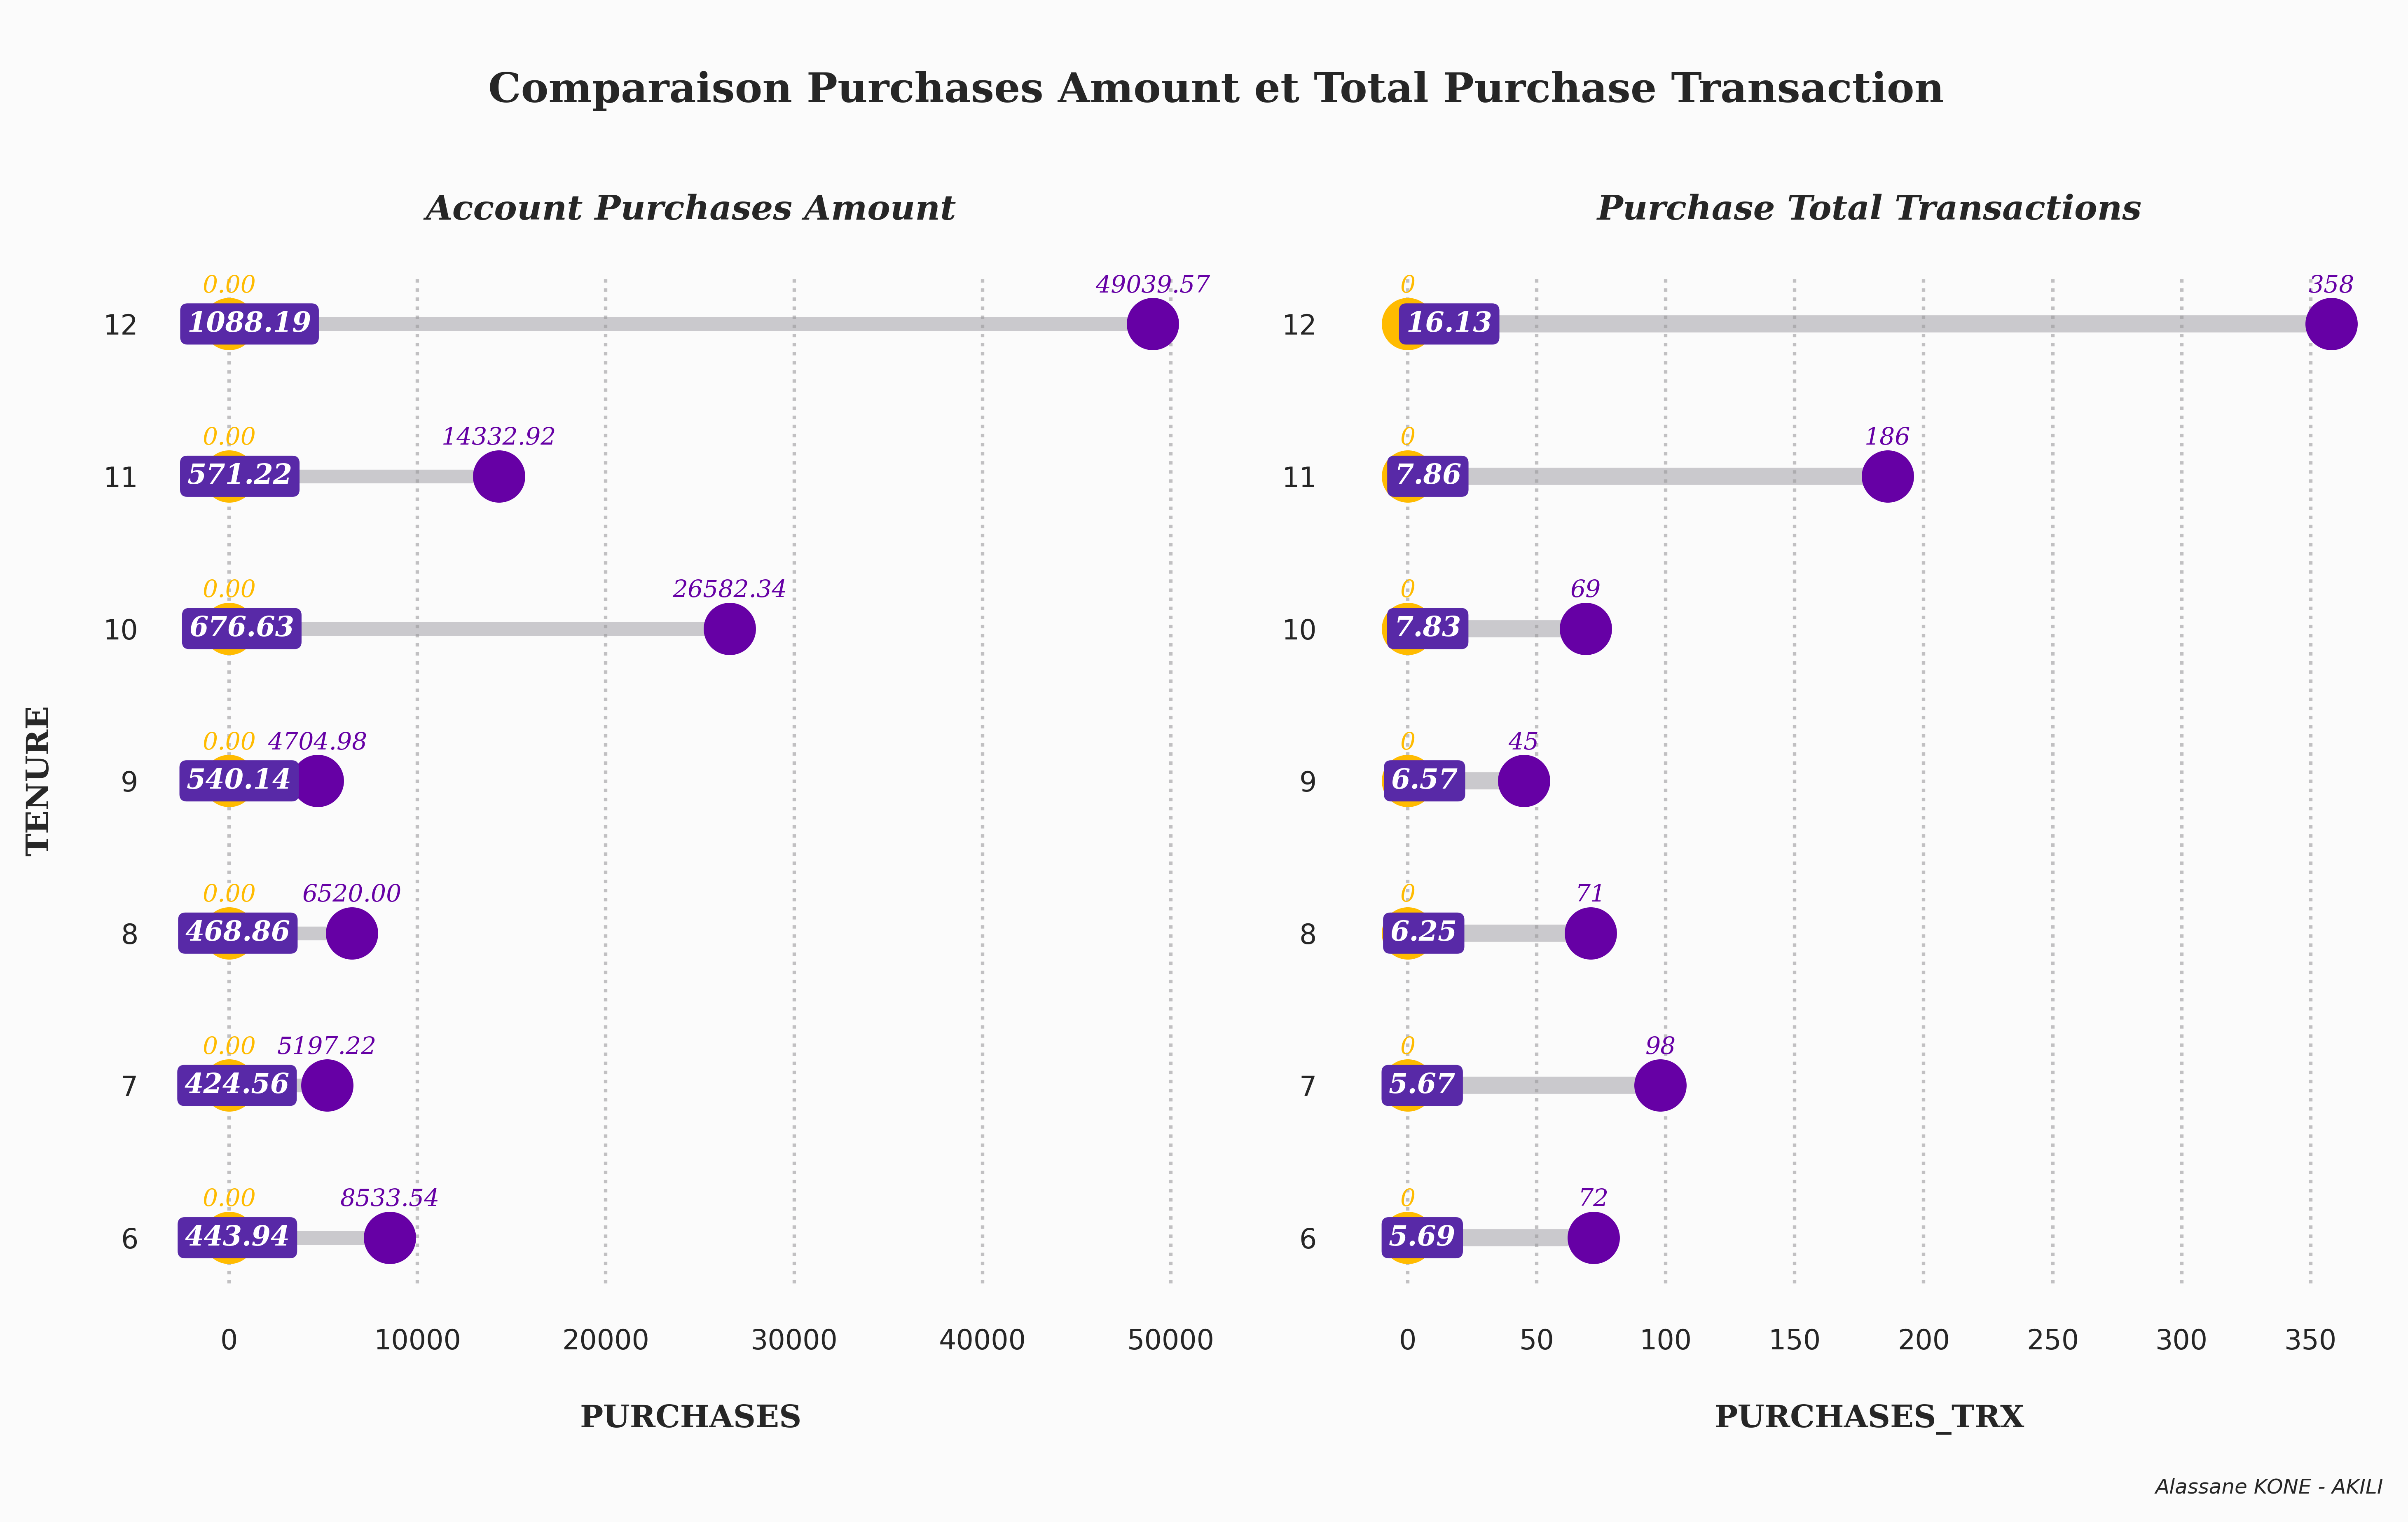

In [ ]:
# --- EDA 2 Variables ---
title=dict(fontsize=10, fontfamily='serif', style='italic', weight='bold', ha='center')
grid_style = dict(alpha=0.6, color='#9B9A9C', linestyle='dotted', zorder=1)
sct_style = dict(s=175, linewidth=2)
xy_label = dict(fontweight='bold', fontsize=9, fontfamily='serif')
ann_style = dict(xytext=(0, 0), textcoords='offset points', va='center', ha='center', style='italic', fontfamily='serif')
tenure = sorted(df['TENURE'].unique())
color_pallete = ['#2D0F51', '#FF9A00', '#6600A5', '#FFD61E', '#722E9A', '#FFE863', '#A486D5']

# --- EDA 2.1 Data Frame ---
eda2_1 = df[['PURCHASES', 'TENURE']]
eda2_1 = eda2_1.groupby('TENURE').agg(MIN=('PURCHASES', 'min'), AVG=('PURCHASES', 'mean'), MAX=('PURCHASES', 'max')).reset_index()

# --- EDA 2.2 Data Frame ---
eda2_2 = df[['PURCHASES_TRX', 'TENURE']]
eda2_2 = eda2_2.groupby('TENURE').agg(MIN=('PURCHASES_TRX', 'min'), AVG=('PURCHASES_TRX', 'mean'), MAX=('PURCHASES_TRX', 'max')).reset_index()

# --- EDA 2.1 & 2.2 Settings ---
fig = plt.figure(figsize=(10, 6))
plt.suptitle('\nComparaison Purchases Amount et Total Purchase Transaction', fontweight='heavy', fontsize=12, fontfamily='serif')

# --- EDA 2.1 (Left Dumbbell) ---
plt.subplot(1, 2, 1)
plt.tight_layout(rect=[0, 0, 1, 1.01])
axs_left=plt.gca()
min_sct = plt.scatter(x=eda2_1['MIN'], y=eda2_1['TENURE'], c='#FFBB00', **sct_style)
max_sct = plt.scatter(x=eda2_1['MAX'], y=eda2_1['TENURE'], c='#6600A5', **sct_style)
for i in range(len(tenure)):
    eda2_1_x = eda2_1[eda2_1['TENURE']==tenure[i]]
    plt.hlines(y=eda2_1_x['TENURE'], xmin=eda2_1_x['MIN'], xmax=eda2_1_x['MAX'], linewidth=4, color='#CAC9CD', zorder=0)
    plt.annotate('{0:.2f}'.format(eda2_1_x['MIN'].values[0]), xy=(eda2_1_x['MIN'].values[0], eda2_1_x['TENURE'].values[0]+0.25), color='#FFBB00', fontsize=7, **ann_style)
    plt.annotate('{0:.2f}'.format(eda2_1_x['AVG'].values[0]), xy=(eda2_1_x['AVG'].values[0], eda2_1_x['TENURE'].values[0]), color='w', fontsize=8, fontweight='bold', bbox=dict(boxstyle='round', pad=0.2, color='#5829A7'), **ann_style)
    plt.annotate('{0:.2f}'.format(eda2_1_x['MAX'].values[0]), xy=(eda2_1_x['MAX'].values[0], eda2_1_x['TENURE'].values[0]+0.25), color='#6600A5', fontsize=7, **ann_style)
for spine in axs_left.spines.values():
    spine.set_color('None')
plt.xlabel('\nPURCHASES', **xy_label)
plt.ylabel('TENURE\n', **xy_label)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(axis='y', alpha=0)
plt.grid(axis='x', which='major', **grid_style)
plt.title('\nAccount Purchases Amount\n', **title)

# --- EDA 2.2 (Right Dumbbell) ---
plt.subplot(1, 2, 2)
plt.tight_layout(rect=[0, 0, 1, 1.01])
axs_right=plt.gca()
min_sctt = plt.scatter(x=eda2_2['MIN'], y=eda2_2['TENURE'], c='#FFBB00', **sct_style)
max_sctt = plt.scatter(x=eda2_2['MAX'], y=eda2_2['TENURE'], c='#6600A5', **sct_style)
for i in range(len(tenure)):
    eda2_2_x = eda2_2[eda2_2['TENURE']==tenure[i]]
    plt.hlines(y=eda2_2_x['TENURE'], xmin=eda2_2_x['MIN'], xmax=eda2_2_x['MAX'], linewidth=5, color='#CAC9CD', zorder=0)
    plt.annotate('{:.0f}'.format(eda2_2_x['MIN'].values[0]), xy=(eda2_2_x['MIN'].values[0], eda2_2_x['TENURE'].values[0]+0.25), color='#FFBB00', fontsize=7, **ann_style)
    plt.annotate('{0:.2f}'.format(eda2_2_x['AVG'].values[0]), xy=(eda2_2_x['AVG'].values[0], eda2_2_x['TENURE'].values[0]), color='w', fontsize=8, fontweight='bold', bbox=dict(boxstyle='round', pad=0.2, color='#5829A7'), **ann_style)
    plt.annotate('{:.0f}'.format(eda2_2_x['MAX'].values[0]), xy=(eda2_2_x['MAX'].values[0], eda2_2_x['TENURE'].values[0]+0.25), color='#6600A5', fontsize=7, **ann_style)
for spine in axs_right.spines.values():
    spine.set_color('None')
plt.xlabel('\nPURCHASES_TRX', **xy_label)
plt.ylabel('')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(axis='y', alpha=0)
plt.grid(axis='x', which='major', **grid_style)
plt.title('\nPurchase Total Transactions\n', **title)

plt.gcf().text(0.88, -0.01, 'Alassane KONE - AKILI', style='italic', fontsize=6)
plt.show();

<div class="explain-box">
 À partir du graphique en haltères ci-dessus, on peut conclure que <mark><b>les clients de cartes de crédit ayant une durée de remboursement de 12 mois sont disposés à prendre le montant d'achat et ont plus de transactions d'achat totales que les clients ayant d'autres durées de remboursement</b></mark>. Cela est lié au sujet précédent, où <b>les clients sont plus susceptibles de rembourser leurs dettes sur une longue période pour augmenter le taux d'intérêt</b>. De plus, <mark><b>certain clients ne font délibérément aucune transaction du tout</b></mark> (0 achats et transactions) pour <b>obtenir une limite de crédit élevée</b>, ce qui a un impact sur <b>l'augmentation des scores de crédit et des ratios d'utilisation du crédit</b>.<br><br>
Le graphique ci-dessus montre également que les clients ayant une <b>durée de remboursement de dix mois ont un montant d'achat plus élevé que les clients ayant une durée de remboursement de onze mois</b>. Cependant, cela est inversement proportionnel aux transactions totales, où <b>les clients ayant une durée de remboursement de dix mois ont moins de transactions que les clients ayant une durée de remboursement de onze mois</b>. Un autre exemple est qu'un <b>client ayant une durée de remboursement de sept mois a un montant d'achat inférieur à celui d'un client ayant une durée de remboursement de huit mois</b>. En revanche, <b>les transactions totales pour les clients ayant une durée de remboursement de sept mois sont supérieures à celles des clients ayant une durée de remboursement de huit mois</b>.
</div>


## <div class="header2">5.3 | Credit Limit vs. Installment Purchases 💳🏬</div>


In [ ]:
# --- EDA 3 Variables ---
scatter_style=dict(linewidth=0.65, edgecolor='#100C07', alpha=0.85)
sub_scatter_style_color=dict(s=5, alpha=0.65, linewidth=0.15, zorder=10, edgecolor='#100C07')
sub_scatter_style_grey=dict(s=5, alpha=0.3, linewidth=0.7, zorder=5, color='#CAC9CD')
grid_style=dict(alpha=0.3, color='#9B9A9C', linestyle='dotted', zorder=1)
xy_label=dict(fontweight='bold', fontsize=14, fontfamily='serif')
suptitle=dict(fontsize=22, fontweight='heavy', fontfamily='serif')
title=dict(fontsize=16, fontfamily='serif')
color_pallete=['#2D0F51', '#FF9A00', '#6600A5', '#FFD61E', '#722E9A', '#FFE863', '#A486D5']
sub_axes=[None] * 7

# --- EDA 3 Data Frame ---
eda3 = df[['CREDIT_LIMIT', 'INSTALLMENTS_PURCHASES', 'TENURE']]
eda3['TENURE'] = eda1['TENURE'].astype(str)
tenure = sorted(eda1['TENURE'].unique())

# --- EDA 3 Settings ---
fig = plt.figure(figsize=(15, 20))
gs = fig.add_gridspec(7, 7)
ax = fig.add_subplot(gs[:7, :])
ax.set_aspect(1)

# --- EDA 3: Main Scatter Plot ---
for x in range(len(tenure)):
    eda3_x = eda3[eda3['TENURE']==tenure[x]]
    ax.scatter(eda3_x['CREDIT_LIMIT'], eda3_x['INSTALLMENTS_PURCHASES'], s=80, color=color_pallete[x], **scatter_style)
    ax.set_title("Il n'y a pas d'hétéroscédasticité détectée entre CREDIT_LIMIT et INSTALLMENTS_PURCHASES.\n", loc="left", **title)
    ax.set_xlabel('\nCREDIT_LIMIT', **xy_label)
    ax.set_ylabel('INSTALLMENTS_PURCHASES\n', **xy_label)
    ax.grid(axis='y', which='major', **grid_style)
    ax.grid(axis='x', which='major', **grid_style)
    for spine in ax.spines.values():
        spine.set_color('None')
    for spine in ['bottom', 'left']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('#CAC9CD')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

# --- EDA 3: Sub Plots ---
for idx, tnr in enumerate(tenure):
    sub_axes[idx] = fig.add_subplot(gs[6, idx], aspect=1)
    
    sub_axes[idx].scatter(eda3[eda3['TENURE']!=tnr]['CREDIT_LIMIT'], eda3[eda3['TENURE']!=tnr]['INSTALLMENTS_PURCHASES'], label=tnr, **sub_scatter_style_grey)
    sub_axes[idx].scatter(eda3[eda3['TENURE']==tnr]['CREDIT_LIMIT'], eda3[eda3['TENURE']==tnr]['INSTALLMENTS_PURCHASES'], color=color_pallete[idx], label=tnr, **sub_scatter_style_color)
    
    cnt = (eda3['TENURE']==tnr).sum()
    sub_axes[idx].set_title(f'Tenure {tnr} - ({cnt})', loc='left', fontsize=10, fontfamily='serif')
    sub_axes[idx].set_xticks([])
    sub_axes[idx].set_yticks([])
    for spine in sub_axes[idx].spines.values():
        spine.set_color('None')

# --- EDA 3 XY Limit ---
for axes in [ax] + sub_axes:
    axes.set_xlim(-1000, 31000)
    axes.set_ylim(-1000, 25000)

# --- EDA 3 Title ---
plt.suptitle('Credit Limit vs. Installment Purchases sachant Tenure', x=0.123, y=0.785, ha='left', **suptitle)
plt.gcf().text(0.82, 0.12, 'Alassane KONE - AKILI', style='italic', fontsize=8)
plt.show();

Output hidden; open in https://colab.research.google.com to view.

<div class="explain-box">
   Le graphique en nuage de points montre <mark><b>aucune corrélation entre les deux variables</b></mark> car le graphique en nuage de points montre un <b>modèle aléatoire</b>.
</div>


# <div class="header1">6. | Prétraitements des données 🔨</div>
<div class="explain-box">
  
</div>

## <div class="header2">6.1 | Dropping Variables 🔻</div>
<div class="explain-box">
   La première étape consiste à <mark><b>supprimer les variables qui ne sont pas nécessaires</b></mark> pour le processus de regroupement. Dans ce cas, <b>CUST_ID sera supprimé</b> car il a des valeurs uniques.
</div>


In [ ]:
df = df[df.columns[1:]]

## <div class="header2">6.2 | Imputation 🧹</div>
<div class="explain-box">
Puisque l'ensemble de données concerne le regroupement, l'imputation utilisera <code>KNNImputer()</code> pour <mark><b>éviter des résultats de regroupement biaisés</b></mark>. La <b>valeur moyenne des n_neighbors les plus proches</b> trouvée dans l'ensemble de données est utilisée pour imputer les valeurs manquantes pour chaque échantillon.
</div>


In [ ]:
df['CREDIT_CARD_TYPE']=df['CREDIT_CARD_TYPE'].fillna('American Express')
df['ACCOUNT_TYPE']=df['ACCOUNT_TYPE'].fillna('Compte épargne')
df['INCOME_CATEGORY']=df['INCOME_CATEGORY'].fillna('Élevé')
df['TYPE_OF_ECO_ACTIVITY']=df['TYPE_OF_ECO_ACTIVITY'].fillna('Investisseurs')

In [ ]:
data = df[df.columns[:-4]]
data

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6
8946,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,NaN,0.000000,6
8947,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6
8948,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6


In [ ]:
# --- List Null Columns ---
null_columns = data.columns[data.isnull().any()].tolist()

# --- Perform Imputation ---
imputer = KNNImputer()
df_imp = pd.DataFrame(imputer.fit_transform(data[null_columns]), columns=null_columns)
data = data.fillna(df_imp)

# --- Showing Dataframe ---
print(clr.start+'.: Dataframe après Imputation :.'+clr.end)
print(clr.color+'*' * 33)
data.head().style.background_gradient(cmap='afmhot_r').hide_index()

.: Dataframe après Imputation :.
*********************************


BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
40.900749,0.818182,95.400000,0.000000,95.400000,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.000000,201.802084,139.509787,0.000000,12
3202.467416,0.909091,0.000000,0.000000,0.000000,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.000000,4103.032597,1072.340217,0.222222,12
2495.148862,1.000000,773.170000,773.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.000000,622.066742,627.284787,0.000000,12
1666.670542,0.636364,1499.000000,1499.000000,0.000000,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.000000,0.000000,1215.951453,0.000000,12
817.714335,1.000000,16.000000,16.000000,0.000000,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.000000,678.334763,244.791237,0.000000,12


## <div class="header2">6.3 | Scaling /Mise à l'échelle 📐</div>
<div class="explain-box">
    L'étape suivante consiste à <mark><b>mettre à l'échelle</b></mark> l'ensemble de données. La mise à l'échelle est essentielle car elle gère la <b>variabilité de l'ensemble de données</b>, <b>transforme les données en une plage définie</b> en utilisant une transformation linéaire pour produire des regroupements de haute qualité, et <b>augmente la précision des algorithmes de regroupement</b>. Dans ce cas, un <mark><b>standard scaler</b></mark> est utilisé pour <b>standardiser les fonctionnalités en supprimant la moyenne et en les mettant à l'échelle à la variance unitaire</b>.
</div>


In [ ]:
# --- Scaling Dataset w/ Standard Scaler ---
X = pd.DataFrame(StandardScaler().fit_transform(data))

## <div class="header2">6.4 | Test de Hopkins🧪</div>
<div class="explain-box">
    La prochaine étape consiste à effectuer un test statistique à l'aide du test statistique de Hopkins</b></mark> pour l'ensemble de données prétraité afin de mesurer la tendance de regroupement des données)</b> (mesurer dans quelle mesure des groupes existent dans les données à regrouper.<br><br>L'hypothèse du test statistique de Hopkins est la suivante:</b>.
    <blockquote style="color: #000000;">
      <ul>
          <li><b>H<sub>0</sub></b>: L'ensemble de données <mark><b>n'est pas uniformément réparti </b></mark> (contient des groupes significatifs).</li>
          <li><b>H<sub>1</sub></b>:  L'ensemble de données <mark><b> est uniformément réparti </b></mark> (aucun groupe significatif).</li>
      </ul>
    </blockquote>
    <b>Critères:</b>
    <blockquote style="color: #000000;">
      <ul>
          <li>Si la valeur est entre 0,7 et 0,99 </b>, <mark><b> accepter H<sub>0</sub></b></mark> (il a une forte tendance à se regrouper).</li>
      </ul>
    </blockquote>
</div>

In [ ]:
# --- Test de Hopkins   ---
def hopkins(X):
    d = X.shape[1]
    n = len(X)
    m = int(0.1 * n)
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print (ujd, wjd)
        H = 0

    return H

In [ ]:
# --- Implémentation du test de Hopkins ---
hopkins_value = hopkins(X)
hopkins_result = 'Resultats: '+clr.start+'{:.4f}'.format(hopkins_value)+clr.end
print(clr.start+'.: Test de  Hopkins :.'+clr.end)
print(clr.color+'*' * 19+clr.end) 
print(hopkins_result)
if  0.7 < hopkins_value < 0.99:
    print('>> À partir des résultats ci-dessus,'+clr.color+' il a une forte tendance à se regrouper (contient des groupes significatifs)'+clr.end)
    print('\n'+clr.color+'*' * 31+clr.end)
    print(clr.start+'.:. Conclusion: On accepte H0 .:.'+clr.end) 
    print(clr.color+'*' * 50+clr.end)
else:
    print('>> À partir des résultats ci-dessus,'+clr.color+' il n\'y a pas de groupes significatifs'+clr.end)
    print('\n'+clr.color+'*' * 50+clr.end)
    print(clr.start+'.:. Conclusion: Rejecter H0 .:.'+clr.end)
    print(clr.color+'*' * 50+clr.end)

.: Test de  Hopkins :.
*******************
Resultats: 0.9684
>> À partir des résultats ci-dessus, il a une forte tendance à se regrouper (contient des groupes significatifs)

*******************************
.:. Conclusion: On accepte H0 .:.
**************************************************
